In [ ]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.9 MB/s eta 0:00:00


In [ ]:
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.7 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376475 sha256=e36d97419401d6cf03520c99962a2b476fe9ec731e4794a402ba5ff47252f3bb
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1


In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
GAMMA = 0.99
TAU = 0.005
LR = 1e-3
ALPHA = 0.2
BATCH_SIZE = 32
REPLAY_SIZE = 100000
TARGET_UPDATE_INTERVAL = 1
EVAL_EPISODES = 5

In [ ]:
# Environment
env = gym.make("CartPole-v1")
# env = TimeLimit(env.env, max_episode_steps=200)
state_dim = env.observation_space.shape[0]  # 4
action_dim = env.action_space.n  # 2

# Replay Buffer
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def size(self):
        return len(self.buffer)

# Neural Networks
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.q1 = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)  # Q-values for each action
        )
        self.q2 = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)  # Q-values for each action
        )

    def forward(self, state):
        q1 = self.q1(state)
        q2 = self.q2(state)
        return q1, q2

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)  # Logits for action probabilities
        )

    def forward(self, state):
        logits = self.network(state)
        probabilities = torch.softmax(logits, dim=-1)
        return probabilities, logits

# Helper Functions
def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            tau * source_param.data + (1 - tau) * target_param.data
        )

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
replay_buffer = ReplayBuffer(REPLAY_SIZE)

actor = Actor(state_dim, action_dim).to(device)
critic = Critic(state_dim, action_dim).to(device)
critic_target = Critic(state_dim, action_dim).to(device)
critic_target.load_state_dict(critic.state_dict())

actor_optimizer = optim.Adam(actor.parameters(), lr=LR)
critic_optimizer = optim.Adam(critic.parameters(), lr=LR)

# Entropy Temperature
target_entropy = -np.log(1.0 / action_dim) * 0.95  # Encourage exploration
log_alpha = torch.zeros(1, requires_grad=True, device=device)
alpha_optimizer = optim.Adam([log_alpha], lr=LR)

def update_alpha(action_probs):
    log_probs = torch.log(action_probs + 1e-8)
    entropy = -torch.sum(action_probs * log_probs, dim=1).mean()
    alpha_loss = -(log_alpha * (entropy - target_entropy).detach()).mean()
    alpha_optimizer.zero_grad()
    alpha_loss.backward()
    alpha_optimizer.step()
    return log_alpha.exp().item()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Training Metrics
episode_rewards = []
actor_losses = []
critic_losses = []
entropies = []

# Training Loop
def train():
    global ALPHA

    if replay_buffer.size() < BATCH_SIZE:
        return

    # Sample from replay buffer
    states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

    # Critic Loss
    with torch.no_grad():
        next_action_probs, _ = actor(next_states)
        next_q1, next_q2 = critic_target(next_states)
        next_q = torch.min(next_q1, next_q2)
        next_action_log_probs = torch.log(next_action_probs + 1e-8)
        target_q = rewards + GAMMA * (1 - dones) * (
            (next_action_probs * (next_q - ALPHA * next_action_log_probs)).sum(dim=1, keepdim=True)
        )

    current_q1, current_q2 = critic(states)
    chosen_q1 = current_q1.gather(1, actions)
    chosen_q2 = current_q2.gather(1, actions)
    critic_loss = ((chosen_q1 - target_q).pow(2).mean() +
                   (chosen_q2 - target_q).pow(2).mean())
    critic_losses.append(critic_loss.item())
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    # Actor Loss
    action_probs, _ = actor(states)
    q1, q2 = critic(states)
    q = torch.min(q1, q2)
    log_probs = torch.log(action_probs + 1e-8)
    actor_loss = (action_probs * (-ALPHA * log_probs - q)).sum(dim=1).mean()
    actor_losses.append(actor_loss.item())
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    # Update ALPHA
    ALPHA = update_alpha(action_probs)
    entropies.append(-torch.sum(action_probs * log_probs, dim=1).mean().item())

    # Update Target Networks
    soft_update(critic_target, critic, TAU)

In [ ]:
# Main Loop
num_episodes = 2000
n_steps = 0
time_steps_per_episode = []
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    while True:
        state_tensor = torch.FloatTensor(np.array(state)).unsqueeze(0).to(device)
        with torch.no_grad():
            action_probs, _ = actor(state_tensor)
        action = np.random.choice(action_dim, p=action_probs.cpu().numpy()[0])

        next_state, reward, done, _ = env.step(action)
        # reward = reward / 10.0
        replay_buffer.add((state, action, reward, next_state, done))
        n_steps += 1
        state = next_state
        episode_reward += reward
        train()
        if done:
            time_steps_per_episode.append(n_steps)
            episode_rewards.append(episode_reward)
            print(f"Episode {episode}, Reward: {episode_reward}, "
                  f"Actor Loss: {np.mean(actor_losses[-10:]):.4f}, "
                  f"Critic Loss: {np.mean(critic_losses[-10:]):.4f}, "
                  f"Entropy: {np.mean(entropies[-10:]):.4f}")
            break

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode 0, Reward: 31.0, Actor Loss: nan, Critic Loss: nan, Entropy: nan
Episode 1, Reward: 8.0, Actor Loss: -0.0082, Critic Loss: 2.4920, Entropy: 0.6028
Episode 2, Reward: 12.0, Actor Loss: -1.2135, Critic Loss: 0.4074, Entropy: 0.1245
Episode 3, Reward: 10.0, Actor Loss: -0.9211, Critic Loss: 0.1261, Entropy: 0.0075
Episode 4, Reward: 10.0, Actor Loss: -1.0801, Critic Loss: 0.0658, Entropy: 0.0008
Episode 5, Reward: 8.0, Actor Loss: -1.0737, Critic Loss: 0.0482, Entropy: 0.0003
Episode 6, Reward: 8.0, Actor Loss: -1.1626, Critic Loss: 0.0203, Entropy: 0.0002
Episode 7, Reward: 9.0, Actor Loss: -1.2410, Critic Loss: 0.0143, Entropy: 0.0001
Episode 8, Reward: 10.0, Actor Loss: -1.2770, Critic Loss: 0.0124, Entropy: 0.0001
Episode 9, Reward: 10.0, Actor Loss: -1.3197, Critic Loss: 0.0163, Entropy: 0.0001
Episode 10, Reward: 10.0, Actor Loss: -1.3628, Critic Loss: 0.0130, Entropy: 0.0001
Episode 11, Reward: 8.0, Actor Loss: -1.3930, Critic Loss: 0.0167, Entropy: 0.0001
Episode 12, Rewar

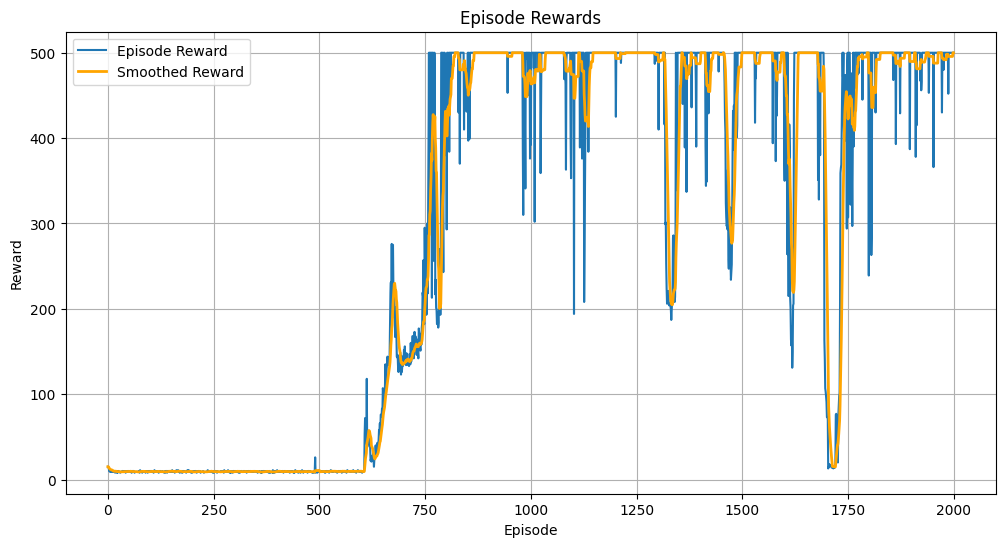

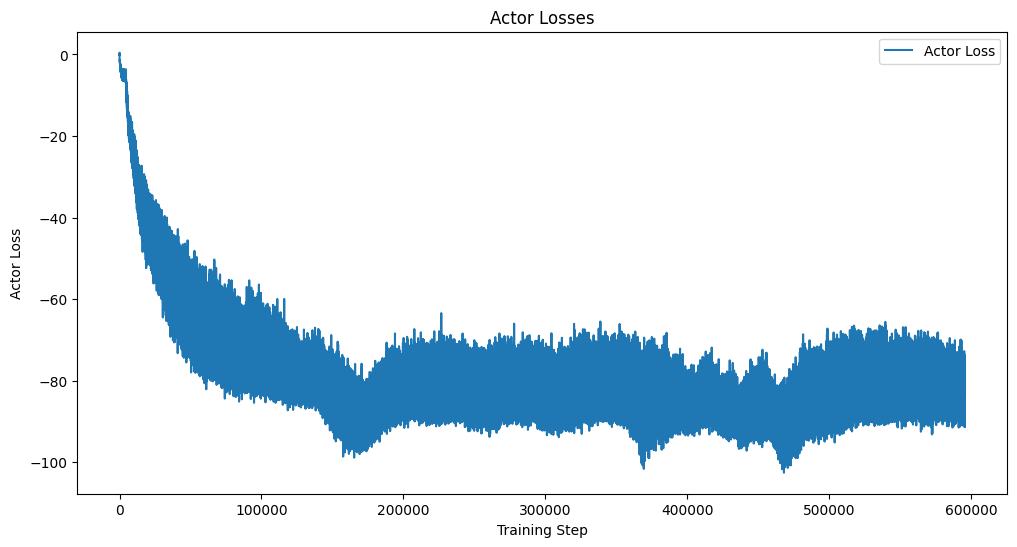

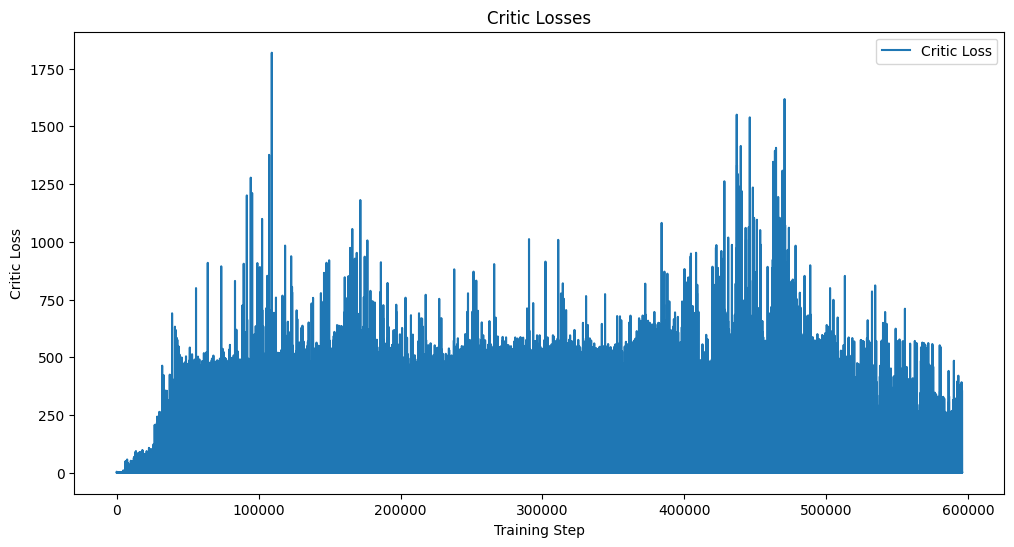

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label="Episode Reward")
smoothed_rewards = [np.mean(episode_rewards[max(0, i-10):i+1]) for i in range(len(episode_rewards))]
plt.plot(smoothed_rewards, label="Smoothed Reward", color="orange", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards")
plt.legend()
plt.grid()
plt.show()

# Losses
plt.figure(figsize=(12, 6))
plt.plot(actor_losses, label='Actor Loss')
plt.xlabel('Training Step')
plt.ylabel('Actor Loss')
plt.title('Actor Losses')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(critic_losses, label='Critic Loss')
plt.xlabel('Training Step')
plt.ylabel('Critic Loss')
plt.title('Critic Losses')
plt.legend()


# # plt.tight_layout()
# plt.show()